### Import Library Dependencies

In [1]:
import os
import sys
import traceback
import logging as log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from microgrid_env import MicrogridEnv
from q_learning_agent import QLearningAgent
from torch.utils.tensorboard.writer import SummaryWriter

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)

log.basicConfig(format="Line:%(lineno)d-%(funcName)s-%(levelname)s:  %(message)s")
log.getLogger().setLevel(log.INFO)

### Environment Data Pre-processing

In [2]:
df = pd.read_csv("load_profile_data_nov2024.csv", header=0)

In [3]:
df.head()

,entry_time,weekday,tou_time_slot,grid_import_energy,solar_prod_energy,solar_ctlr_setpoint,site_load_energy
0,11/1/24 0:00,Friday,o,1339.4,0.0,100.0,1339.4
1,11/1/24 1:00,Friday,o,1388.9,0.0,100.0,1388.9
2,11/1/24 2:00,Friday,o,1444.8,0.0,100.0,1444.8
3,11/1/24 3:00,Friday,o,1463.7,0.0,100.0,1463.7
4,11/1/24 4:00,Friday,o,1467.0,0.0,100.0,1467.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   entry_time           720 non-null    object 
 1   weekday              720 non-null    object 
 2   tou_time_slot        720 non-null    object 
 3   grid_import_energy   720 non-null    float64
 4   solar_prod_energy    720 non-null    float64
 5   solar_ctlr_setpoint  720 non-null    float64
 6   site_load_energy     720 non-null    float64
dtypes: float64(4), object(3)
memory usage: 39.5+ KB


In [5]:
df['timestamp'] = pd.to_datetime(df['entry_time'], format="mixed")

In [6]:
df['ts_hour'] = df['timestamp'].dt.hour

In [7]:
def convert_weekday(wkd: str) -> str:
    if wkd in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        return 'week'
    else:
        return wkd.lower()

In [8]:
# One-hot encode the Weekday field
df['weekday_fmt'] = df['weekday'].map(lambda wkd: convert_weekday(wkd))
df['day_week'] = df['weekday_fmt'].map(lambda wkd: 1 if wkd == 'week' else 0)
df['day_saturday'] = df['weekday_fmt'].map(lambda wkd: 1 if wkd == 'saturday' else 0)
df['day_sunday'] = df['weekday_fmt'].map(lambda wkd: 1 if wkd == 'sunday' else 0)

In [9]:
# One-hot encode the TOU Timeslot field
df['tou_offpeak'] = df['tou_time_slot'].map(lambda tou: 1 if tou == 'o' else 0)
df['tou_standard'] = df['tou_time_slot'].map(lambda tou: 1 if tou == 's' else 0)
df['tou_peak'] = df['tou_time_slot'].map(lambda tou: 1 if tou == 'p' else 0)

In [10]:
# Convert hour field to unit circle coordinates
df['ts_hour_sin'] = np.sin( df['ts_hour'] )
df['ts_hour_cos'] = np.cos( df['ts_hour'] )

In [11]:
df.set_index('timestamp', inplace=True)

In [12]:
df.drop(['entry_time', 'ts_hour', 'weekday', 'weekday_fmt', 'tou_time_slot'], axis=1, inplace=True)

In [13]:
load_profile_df = df[['ts_hour_sin', 'ts_hour_cos', 'tou_offpeak', 'tou_standard', 'tou_peak', 'day_week', 'day_saturday', 'day_sunday', 'site_load_energy', 'solar_prod_energy', 'solar_ctlr_setpoint', 'grid_import_energy']]

In [14]:
load_profile_df.head(48)

,ts_hour_sin,ts_hour_cos,tou_offpeak,tou_standard,tou_peak,day_week,day_saturday,day_sunday,site_load_energy,solar_prod_energy,solar_ctlr_setpoint,grid_import_energy
timestamp,,,,,,,,,,,,
2024-11-01 00:00:00,0.000000,1.000000,1,0,0,1,0,0,1339.40,0.00,100.000,1339.4
2024-11-01 01:00:00,0.841471,0.540302,1,0,0,1,0,0,1388.90,0.00,100.000,1388.9
2024-11-01 02:00:00,0.909297,-0.416147,1,0,0,1,0,0,1444.80,0.00,100.000,1444.8
2024-11-01 03:00:00,0.141120,-0.989992,1,0,0,1,0,0,1463.70,0.00,100.000,1463.7
2024-11-01 04:00:00,-0.756802,-0.653644,1,0,0,1,0,0,1467.00,0.00,100.000,1467.0
2024-11-01 05:00:00,-0.958924,0.283662,1,0,0,1,0,0,1402.91,24.21,100.000,1378.7
2024-11-01 06:00:00,-0.279415,0.960170,0,0,1,1,0,0,1458.70,173.80,100.000,1284.9
2024-11-01 07:00:00,0.656987,0.753902,0,0,1,1,0,0,1488.20,519.50,100.000,968.7
2024-11-01 08:00:00,0.989358,-0.145500,0,0,1,1,0,0,1442.50,851.60,100.000,590.9


In [15]:
load_profile_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ts_hour_sin,720.0,0.040825,0.697899,-0.999990,-0.595763,0.070560,0.701904,0.990607
ts_hour_cos,720.0,-0.022538,0.715646,-0.999961,-0.680155,-0.070537,0.683713,1.000000
tou_offpeak,720.0,0.443056,0.497092,0.000000,0.000000,0.000000,1.000000,1.000000
tou_standard,720.0,0.411111,0.492377,0.000000,0.000000,0.000000,1.000000,1.000000
tou_peak,720.0,0.145833,0.353184,0.000000,0.000000,0.000000,0.000000,1.000000
day_week,720.0,0.700000,0.458576,0.000000,0.000000,1.000000,1.000000,1.000000
day_saturday,720.0,0.166667,0.372937,0.000000,0.000000,0.000000,0.000000,1.000000
day_sunday,720.0,0.133333,0.340171,0.000000,0.000000,0.000000,0.000000,1.000000
site_load_energy,720.0,1243.478583,327.529219,0.000000,1063.915000,1322.400000,1488.250000,1934.700000
solar_prod_energy,720.0,306.043861,414.502550,0.000000,0.000000,36.000000,561.375000,1443.100000


In [16]:
# Filter the load profile data for a specific date period
load_profile_filtered_df = load_profile_df.loc['2024-11-04':'2024-11-10']

In [17]:
load_profile_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2024-11-04 00:00:00 to 2024-11-10 23:00:00
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ts_hour_sin          168 non-null    float64
 1   ts_hour_cos          168 non-null    float64
 2   tou_offpeak          168 non-null    int64  
 3   tou_standard         168 non-null    int64  
 4   tou_peak             168 non-null    int64  
 5   day_week             168 non-null    int64  
 6   day_saturday         168 non-null    int64  
 7   day_sunday           168 non-null    int64  
 8   site_load_energy     168 non-null    float64
 9   solar_prod_energy    168 non-null    float64
 10  solar_ctlr_setpoint  168 non-null    float64
 11  grid_import_energy   168 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 17.1 KB


### Train Q-Learning Agent

In [18]:
best_reward = -999_999

daily_episode_reward = 0.0
daily_episode_memory = []

weekly_episode_reward = 0.0
weekly_episode_memory = []

mini_flex_high_demand_tariff = {'peak_rate': 624.05, 'standard_rate': 189.08, 'offpeak_rate': 102.70}
mini_flex_low_demand_tariff = {'peak_rate': 203.57, 'standard_rate': 140.10, 'offpeak_rate': 88.91}

selected_tariff = mini_flex_high_demand_tariff

env = MicrogridEnv(data = load_profile_filtered_df, 
                   grid_notified_maximum_demand = 2000.0, 
                   bess_capacity = 3000.0, 
                   bess_cycle_efficiency = 0.9, 
                   bess_step_sizes = [1500.0, 1000.0, 500.0, 0.0, 500.0, 1000.0, 1500.0], 
                   tou_peak_tariff = selected_tariff['peak_rate'] / 100.0, 
                   tou_standard_tariff = selected_tariff['standard_rate'] / 100.0, 
                   tou_offpeak_tariff = selected_tariff['offpeak_rate'] / 100.0, 
                   solar_ppa_tariff = 1.4,
                   debug_flag = False)

total_num_steps = 168*10_000

agent = QLearningAgent(env=env, 
                       discounting_factor=0.99,
                       learning_rate=0.05,
                       epsilon_start = 1.0, 
                       epsilon_end = 0.01, 
                       decay_steps = total_num_steps)

iter_no = 1

while True:
    
    iter_no += 1

    # Take one step in the environment
    state, action, reward, next_state = agent.sample_env(use_fixed_rule_policy=False)

    # Hourly q-value update
    agent.value_update(state.index, action, reward, next_state.index)

    daily_episode_reward += reward
    daily_episode_memory.append( (state, action, reward, next_state) )
    
    weekly_episode_reward += reward
    weekly_episode_memory.append( (state, action, reward, next_state) )

    if (iter_no % 24) == 0:

        # print(f"[{iter_no}] daily episode reward: {daily_episode_reward: .2f}")

        # Daily q-value update
        # for state_d, action_d, reward_d, next_state_d in daily_episode_memory:
        #     agent.value_update(state_d.index, action_d, daily_episode_reward, next_state_d.index)

        daily_episode_reward = 0.0
        daily_episode_memory = []
        
        if (iter_no % 168) == 0:
    
            # print(f"[{iter_no}] weekly episode reward: {weekly_episode_reward: .2f}")

            # Weekly q-value update
            # for state_w, action_w, reward_w, next_state_w in weekly_episode_memory:
            #     agent.value_update(state_w.index, action_w, weekly_episode_reward, next_state_w.index)
    
            if weekly_episode_reward > best_reward:
                print(f"[{iter_no}] Best weekly episode reward updated {best_reward: .3f} -> {weekly_episode_reward: .3f}")
                best_reward = weekly_episode_reward
    
            if (best_reward > 120) or (iter_no >= total_num_steps):

                print("\nDone !!!\n")

                print(f"\nSolved in {iter_no} iterations !\n")
    
                print(f"\nBest weekly episode reward: {best_reward: .2f}\n")
                
                test_env = MicrogridEnv(data = load_profile_filtered_df, 
                                        grid_notified_maximum_demand = 2000.0, 
                                        bess_capacity = 3000.0, 
                                        bess_cycle_efficiency = 0.9, 
                                        bess_step_sizes = [1500.0, 1000.0, 500.0, 0.0, 500.0, 1000.0, 1500.0], 
                                        tou_peak_tariff = selected_tariff['peak_rate'] / 100.0, 
                                        tou_standard_tariff = selected_tariff['standard_rate'] / 100.0, 
                                        tou_offpeak_tariff = selected_tariff['offpeak_rate'] / 100.0, 
                                        solar_ppa_tariff = 1.4,
                                        debug_flag = True)
    
                agent.save_learned_policy(env=test_env)

                break
    
            weekly_episode_reward = 0.0
            weekly_episode_memory = []

[168] Best weekly episode reward updated -999999.000 -> -37.209
[2184] Best weekly episode reward updated -37.209 -> -35.776
[3696] Best weekly episode reward updated -35.776 -> -25.405
[15624] Best weekly episode reward updated -25.405 -> -19.826
[17304] Best weekly episode reward updated -19.826 -> -19.326
[20160] Best weekly episode reward updated -19.326 -> -13.433
[64176] Best weekly episode reward updated -13.433 -> -10.977
[72744] Best weekly episode reward updated -10.977 -> -3.713
[93576] Best weekly episode reward updated -3.713 -> -2.403
[178584] Best weekly episode reward updated -2.403 ->  6.546
[203280] Best weekly episode reward updated  6.546 ->  9.014
[275016] Best weekly episode reward updated  9.014 ->  12.412
[322896] Best weekly episode reward updated  12.412 ->  21.765
[427560] Best weekly episode reward updated  21.765 ->  25.893
[427728] Best weekly episode reward updated  25.893 ->  32.411
[551544] Best weekly episode reward updated  32.411 ->  38.745
[581784] 

In [19]:
# agent.display_action_value_table()

### Display Trained Agent's Performance

In [20]:
experience_df = pd.read_csv("agent_learned_policy.csv", header=0)

In [21]:
experience_df.head()

performance_df = experience_df[['day_week',
                                'day_saturday', 
                                'day_sunday', 
                                'tou_peak', 
                                'tou_standard', 
                                'tou_offpeak', 
                                'grid_import_energy', 
                                'solar_prod_energy', 
                                'solar_ctlr_setpoint', 
                                'bess_avail_discharge_energy', 
                                'bess_soc', 
                                'action_name', 
                                'reward_earned']]

performance_df.loc[ : ,'cumulative_reward'] = performance_df['reward_earned'].cumsum()

performance_df.index = load_profile_filtered_df.index

/tmp/ipykernel_47246/1413746927.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_df.loc[ : ,'cumulative_reward'] = performance_df['reward_earned'].cumsum()


In [22]:
# performance_df.head(168)

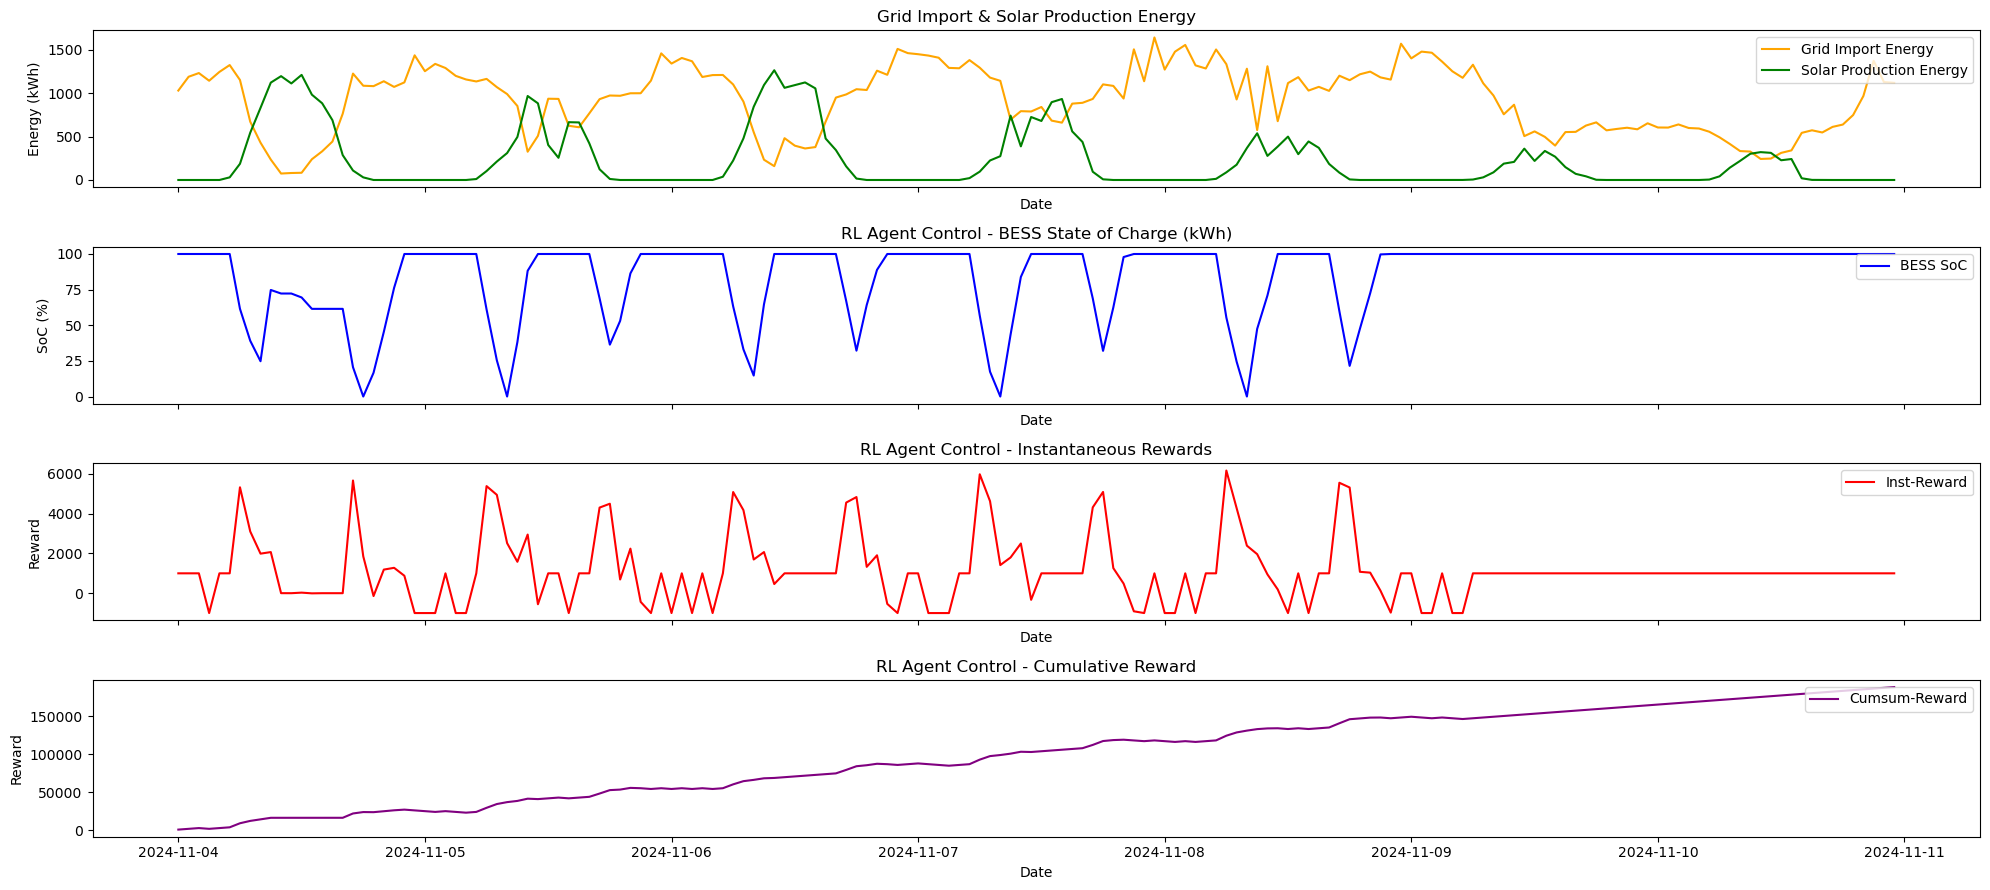

In [23]:
filtered_df = performance_df.loc["2024-11-04": "2024-11-10"]

x = filtered_df.index
y1 = filtered_df['bess_soc'].values
y2 = filtered_df['grid_import_energy'].values
y3 = filtered_df['solar_prod_energy'].values
y4 = filtered_df['reward_earned'].values
y5 = filtered_df['cumulative_reward'].values

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 9), sharex=True)

ax1.plot(x, y2, color='orange', label='Grid Import Energy')
ax1.plot(x, y3, color='green', label='Solar Production Energy')
ax1.set_title('Grid Import & Solar Production Energy')
ax1.set_xlabel('Date')
ax1.set_ylabel('Energy (kWh)')
ax1.legend(loc='upper right')

ax2.set_title('RL Agent Control - BESS State of Charge (kWh)')
ax2.set_xlabel('Date')
ax2.set_ylabel('SoC (%)')
ax2.plot(x, y1, color='blue', label='BESS SoC')
ax2.legend(loc='upper right')

ax3.set_title('RL Agent Control - Instantaneous Rewards')
ax3.set_xlabel('Date')
ax3.set_ylabel('Reward')
ax3.plot(x, y4, color='red', label='Inst-Reward')
ax3.legend(loc='upper right')

ax4.set_title('RL Agent Control - Cumulative Reward')
ax4.set_xlabel('Date')
ax4.set_ylabel('Reward')
ax4.plot(x, y5, color='purple', label='Cumsum-Reward')
ax4.legend(loc='upper right')

fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()